# SPAM detection with NLP processing

The project is to build a model able to dectect wether an SMS is an spam or not. To do so we will first treat the SMS with **NLP mehtod**. 

Then we will try to apply an **classification model** on the treated SMS



### package import

In [259]:
import pandas as pd
import spacy
import re
import numpy as np
from unidecode import unidecode
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords

#change the working directory if necessary
df_eng=pd.read_csv(r'C:\Users\UTILISATEUR\Desktop\Spam\Spam_dataset.csv',sep=';')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UTILISATEUR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **EDA** (Exploratory Data Analysis)

In [260]:
df_eng['Nature'].value_counts()

ham     4825
spam     747
Name: Nature, dtype: int64

Ham is over represented we risk that the model will overfit on the ham. We will ve carefull before trying to build a predictive model

In [261]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

#### Features extraction

In [262]:
#Count upper case
from numpy import count_nonzero


df_eng['count_upper']=df_eng.SMS.apply(lambda text: len(re.findall(r'[A-Z]',text))/len(text))

#replace hours
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?(am|pm)' , 'hour',x))

#Number of words containing letters and number
df_eng['count_nonword']=df_eng.SMS.apply(lambda text: len(re.findall(r'(?:[a-zA-Z]+[0-9]+|[0-9]+[a-zA-Z])[a-zA-Z0-9]*',text))/len(text))

#Length message
df_eng['length']=df_eng.SMS.apply(lambda text: len(text))

#punctuation "..."
df_eng['count_suspension']=df_eng.SMS.apply(lambda text: len(re.findall(r'\.\.\.',text)))




### Cleaning the sms

In [263]:

#Remove upper case
df_eng.SMS=df_eng.SMS.str.lower()
#remove accent
df_eng.SMS=df_eng.SMS.apply(lambda text: unidecode(text))


#punctuation "..."

# Replace email address with 'emailaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress',x))
# Replace urls with 'webaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^http?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+(\.[a-zA-Z]+){1,4}', 'webaddress',x))


# Replace money symbol with 'money-symbol'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^(( )*\£{0,1}( )*)\d*(.\d{1,2})?$', 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'PS\d+(,\d+)?' , 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?p' , 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?ppm' , 'moneynumb',x))




#replace numbers
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d{10,15}','phonenumber',x))
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d+','number',x))


#retirer la ponctuation
df_eng.SMS=df_eng.SMS.apply(lambda text: text.translate(str.maketrans(string.punctuation ,' '*len(string.punctuation ))
                                                             ).replace(' '*4,' ').replace(' '*3,' ').replace(' '*2,' ').strip())

### Lemmatize the sms

In [264]:
#Function to lemmatize the text and take out some ponctuation and the names of peoples
def lemmatize(text):
    lemmatized_array=[]
    doc=nlp(u'{}'.format(text))
    for token in doc:
        if token.lemma_ not in ("'",",","[","]") and (not token.ent_type_ == "PER"):
            lemmatized_array.append(token.lemma_)
    return lemmatized_array

In [265]:
df_nlp_eng=df_eng.copy()

In [266]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda x: lemmatize(x))

### Stopwords treatment

In [267]:
stopWords = set(stopwords.words('english'))
stopWords.update(('nt','pl','c'))
def remove_sw(text):
    return[w for w in text if w not in stopWords]

In [268]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda text: remove_sw(text))

### Word cloud

In [269]:
df_cloud=df_nlp_eng.copy()

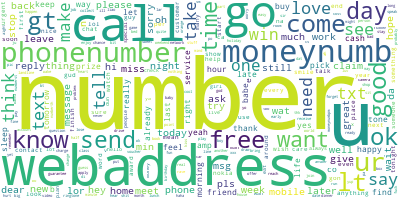

In [270]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
df_cloud.SMS=df_cloud.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

##### Word cloud of spams and non spam

In [271]:
df_cloud_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_cloud_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']

c:\Users\UTILISATEUR\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


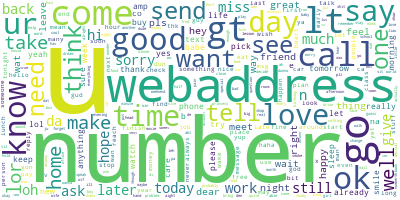

In [272]:
df_cloud_ham.SMS=df_cloud_ham.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_ham.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

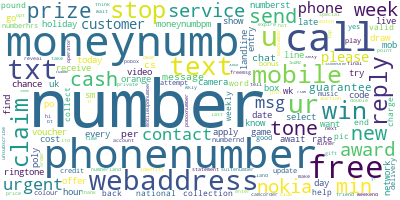

In [273]:
df_cloud_spam.SMS=df_cloud_spam.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_spam.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Predictive model

#### Downsampling the data

In [274]:
# check percentage of data - states how much data needs to be balanced
print(str(round(747/4825,2))+'%')

0.15%


In [275]:
#clear empty fields
df_nlp_eng=df_nlp_eng[df_nlp_eng['SMS'].map(len)>0]

#we separe the two type of data
df_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']


df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

# get the balanced dataset
df_model= pd.concat([df_spam , df_ham_downsampled])

In [276]:
#Change the categorical variable to numerical one
df_model['is_spam']=df_model['Nature'].apply(lambda x: 1 if x=='spam'else 0)

#### Compute the TF-IDF score

In [277]:
#Join the list of word to apply the tf_idf
df_model.SMS=df_model.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model.SMS)

In [278]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model.index,inplace=True)

In [279]:
#Concatenate the score of tf-idf and the initial dataframe
df_model=pd.concat([df_model , tfidf_df],axis=1)

#### Random Forest Classifier Reg

In [280]:
#Separate the training set in differents one
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y_model=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y_model, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

<ipython-input-280-87debd1ae916>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [281]:
df_=(df_model.merge(X_test, left_index=True,right_index=True ,how='inner')).merge(pd.DataFrame({'pred':list(y_pred),'index': X_test.index}).set_index('index'),left_index=True,right_on='index')


In [282]:
for i in df_[df_['is_spam']!=df_['pred']].index:
    print(df_.loc[i,'SMS'])

sm ac sptv new jersey devil detroit red wing play ice hockey correct incorrect end reply end sptv
unique enough find numberth august webaddress
important customer service announcement premier
reminder download content already pay goto http doit mymoby tv collect content
buy one ringtone get text cost number pound offer tone etc
would like see xxx pic hot nearly ban uk
number number free text message valid number december number
number free ringtone reply real
hi ya babe x u numbergoten bout I scammer get webaddress regular vodafone respond get prem rate msg subscription nos use also beware
guess I first time I create web page webaddress read I write I wait opinion I want friend number number
hello darle today I would love chat tell I look like sexy
freemsg fav xma tone reply real
unsubscribed service get ton sexy babe hunk straight phone go webaddress subscription
life never much fun great come make truly special I I win forget enjoy one gbp sm
save money wedding lingerie webaddress ch

In [283]:
df_[df_['is_spam']!=df_['pred']]

,Nature,SMS,count_upper_x,count_nonword_x,length_x,count_suspension_x,is_spam,aah_x,ab_x,aberdeen_x,...,yunny_y,yup_y,yupz_y,ze_y,zebra_y,zindgi_y,zoe_y,zouk_y,zyada_y,pred
index,,,,,,,,,,,,,,,,,,,,,
54,spam,sm ac sptv new jersey devil detroit red wing p...,0.200000,0.000000,120,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
191,spam,unique enough find numberth august webaddress,0.041667,0.013889,72,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
752,spam,important customer service announcement premier,0.123077,0.000000,65,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
881,spam,reminder download content already pay goto htt...,0.023622,0.000000,127,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1460,spam,buy one ringtone get text cost number pound of...,0.012346,0.000000,81,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1875,spam,would like see xxx pic hot nearly ban uk,0.047619,0.000000,84,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1963,spam,number number free text message valid number d...,0.027027,0.000000,74,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2079,spam,number free ringtone reply real,0.333333,0.000000,30,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2247,spam,hi ya babe x u numbergoten bout I scammer get ...,0.022099,0.005525,181,0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Visualisation error

Text(105.0, 0.5, 'Actual')

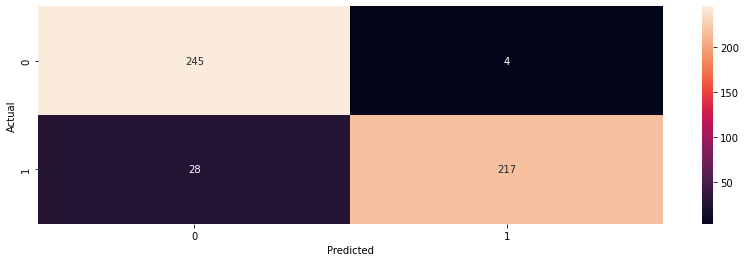

In [284]:
cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Model on the whole dataset

In [285]:
df_test=df_nlp_eng.copy()

In [286]:
#Join the list of word to apply the tf_idf
df_test.SMS=df_test.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_test.SMS)

In [287]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_test.index,inplace=True)

In [288]:
#Concatenate the score of tf-idf and the initial dataframe
df_test=pd.concat([df_test , tfidf_df],axis=1)

In [289]:
X=df_test[df_test.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[np.intersect1d(X.columns, X_model.columns)]
X=X.loc[:,~X.columns.duplicated()]

<ipython-input-290-4fee2d999914>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_t.fit(X_model, y_model)


Text(105.0, 0.5, 'Actual')

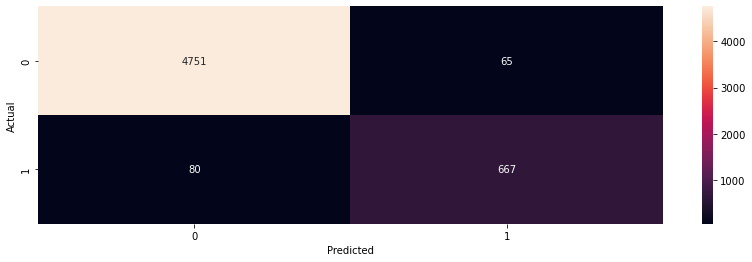

In [290]:
df_test['is_spam']=df_test['Nature'].apply(lambda x: 1 if x=='spam'else 0)

#initialise model

clf_t = RandomForestClassifier(max_depth=2, random_state=0)
X_model=X_model.loc[:,~X_model.columns.duplicated()]
clf_t.fit(X_model, y_model)


X=df_test[df_test.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[np.intersect1d(X.columns, X_model.columns)]
X=X.loc[:,~X.columns.duplicated()]


y=df_test[['is_spam']]
y_pred=clf_t.predict(X)
cm = confusion_matrix(y,y_pred)

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## N-GRAMS

For the N-gram we will use the sentences that are pre-proceced(lemmatize and cleaned of stopword)s

#### Visualization of bi-grams

In [291]:
df_gram=df_nlp_eng.copy()
df_gram['is_spam']=df_gram['Nature'].apply(lambda x: 1 if x=='spam'else 0)

In [292]:
#Fond all the bigram in the texts
def get_grams(data):

    bigrams_final=[]
    bigrams_values=0
    bigrams_labels=0
    for bigram in data.SMS:
        for i in range(0,len(bigram)-1):
            bigram_list_basic=bigram[i]+" "+bigram[i+1]
            bigrams_final.append(bigram_list_basic)

                
    bigrams_final = pd.DataFrame(bigrams_final) 
    bigrams_final.columns=["bigrams"]
    bigrams_values=bigrams_final.groupby("bigrams")["bigrams"].count()
    bigrams_labels=bigrams_final.groupby("bigrams").groups.keys()
    bigrams_final_result = pd.DataFrame(
    {
        "bigram":[*bigrams_labels],
        "count":bigrams_values
    }
    )
    return bigrams_final_result

In [293]:
df_bigram1=get_grams(df_gram[df_gram['is_spam']==1])
df_bigram2=get_grams(df_gram[df_gram['is_spam']==0])

In [294]:
def plot_grams(df_bigram,gram_n,height=4, width=14):
    bigrams_final = df_bigram
    bigrams_final = bigrams_final.sort_values("count",ascending=False).iloc[:15]
    plt.barh(bigrams_final["bigram"],bigrams_final["count"], align="center", alpha=0.7)
    plt.xlabel('Count')
    plt.title('Most common bigrams')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.show()
    plt.rcParams["figure.figsize"] = fig_size

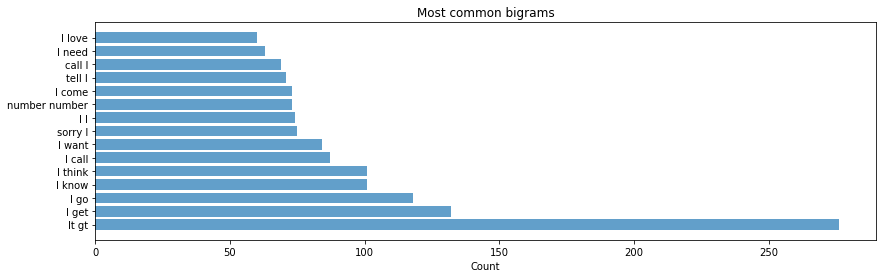

In [295]:
plot_grams(df_bigram2, gram_n=2)

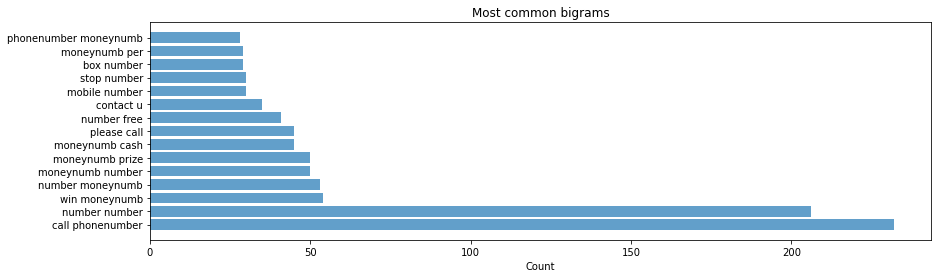

In [296]:
plot_grams(df_bigram1, gram_n=2)

In [297]:
#clear empty fields
df_gram=df_gram[df_gram['SMS'].map(len)>0]

#we separe the two type of data
df_gham=df_gram[df_gram['Nature']=='ham']
df_gspam=df_gram[df_gram['Nature']=='spam']


df_gham_downsampled = df_gham.sample(df_gspam.shape[0])
df_gham_downsampled.shape

# get the balanced dataset
df_model_gram= pd.concat([df_gspam , df_gham_downsampled])

In [298]:
# Getting bigrams 
df_viz=df_model_gram.copy()
df_model_gram.SMS=df_model_gram.SMS.apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(ngram_range =(2, 2))
X1 = vectorizer.fit_transform(df_model_gram.SMS) 
features = (vectorizer.get_feature_names())
print("\n\nX1 : \n", X1.toarray())



X1 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### TF-IDF

In [299]:

# Applying TFIDF
# You can still get n-grams here
vectorizer = TfidfVectorizer(ngram_range = (2, 2))
X2 = vectorizer.fit_transform(df_model_gram.SMS)
scores = (X2.toarray())
print("\n\nScores : \n", scores)
  
# Getting top ranking features
sums = X2.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0, col] ))
ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords : \n", words.head(20))



Scores : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Words : 
                        term       rank
5402          number number  28.838676
806        call phonenumber  27.979725
6325            please call  10.210014
9408          win moneynumb   9.636237
4696        moneynumb prize   9.426325
4173                  lt gt   9.067077
5375       number moneynumb   8.165712
4651         moneynumb cash   8.135668
4684       moneynumb number   7.309663
5279            number free   7.271675
1517       customer service   6.162282
4591          mobile number   5.849281
5571      number webaddress   5.389944
4689          moneynumb per   5.218116
8511            try contact   5.181721
3013         guarantee call   5.172862
6174  phonenumber moneynumb   5.163573
7808            stop number   5.155910
6516        prize guarantee   5.078283
640              box number   5.064769


In [300]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df_gram = pd.DataFrame(scores, columns=vectorizer.get_feature_names())
tfidf_df_gram.set_index(df_model_gram.index,inplace=True)

In [301]:
#Concatenate the score of tf-idf and the initial dataframe
df_model_gram=pd.concat([df_model_gram,tfidf_df_gram],axis=1)

<ipython-input-302-45a583014fb5>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Text(105.0, 0.5, 'Actual')

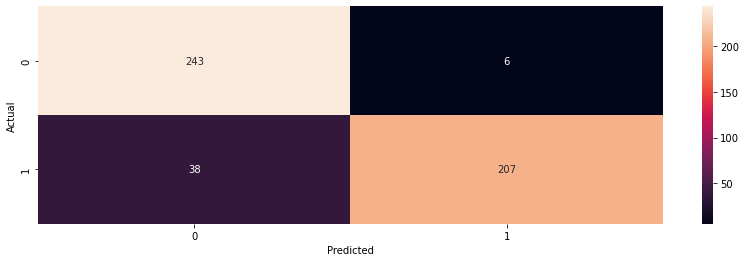

In [302]:
#Separate the training set in differents one
X_model=df_model_gram[df_model_gram.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model_gram[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Combination bi-gram and tf-idf

In [303]:
df_bigram1_2=df_model_gram[df_model_gram['is_spam']==0]
df_bigram2_2=df_model_gram[df_model_gram['is_spam']==1]
lis2=list(df_bigram1_2.loc[:,df_bigram2_2.columns.difference(['Nature', 'SMS', 'count_suspension','length','count_nonword','count_upper', 'is_spam'])].sum().sort_values(ascending=False).head(50).index)
lis=list(df_bigram1_2.loc[:,df_bigram1_2.columns.difference(['Nature', 'SMS', 'count_suspension','length','count_nonword','count_upper', 'is_spam'])].sum().sort_values(ascending=False).head(50).index)

In [304]:
col=['Nature', 'SMS', 'count_suspension','length','count_nonword','count_upper', 'is_spam']
col=col+lis2+lis

In [305]:
vectorizer=TfidfVectorizer()
df_model_gram.SMS=df_viz.SMS.apply(lambda x: ' '.join(x))
X=vectorizer.fit_transform(df_model_gram.SMS)

#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model_gram.index,inplace=True)

#Concatenate the score of tf-idf and the initial dataframe
df_model=df_model_gram[col].merge( tfidf_df,left_index=True, right_index=True)

<ipython-input-306-9f9f79e96d14>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Text(105.0, 0.5, 'Actual')

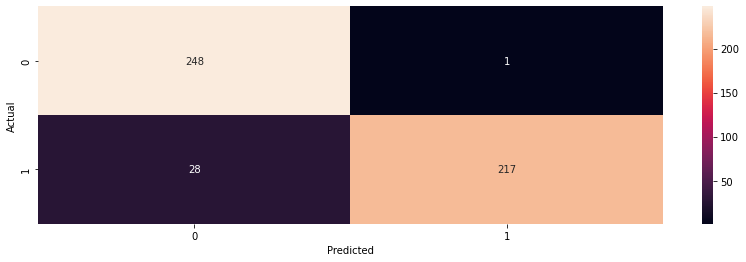

In [306]:
#Separate the training set in differents one
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Whole dataset application


In [307]:
df_model_final=df_nlp_eng.copy()
df_model_final['is_spam']=df_model_final['Nature'].apply(lambda x: 1 if x=='spam'else 0)

#Join the list of word to apply the tf_idf
df_model_final.SMS=df_model_final.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model_final.SMS)

#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model_final.index,inplace=True)

#Concatenate the score of tf-idf and the initial dataframe
df_model_final=pd.concat([df_model_final , tfidf_df],axis=1)

In [308]:
#n-gram addition
vectorizer = CountVectorizer(ngram_range =(2, 2))
X1 = vectorizer.fit_transform(df_model_final.SMS) 
features = (vectorizer.get_feature_names())

# Applying TFIDF
# You can still get n-grams here
vectorizer = TfidfVectorizer(ngram_range = (2, 2))
X2 = vectorizer.fit_transform(df_model_final.SMS)
scores = (X2.toarray())

#Convert the result to a dataframe and reset the index to the right one
tfidf_df_gram = pd.DataFrame(scores, columns=vectorizer.get_feature_names())
tfidf_df_gram.set_index(df_model_final.index,inplace=True)

#Concatenate the score of tf-idf and the initial dataframe
df_model_final=pd.concat([df_model_final,tfidf_df_gram],axis=1)

<ipython-input-318-f60e5940a369>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_t.fit(X_final, y_model)


Text(105.0, 0.5, 'Actual')

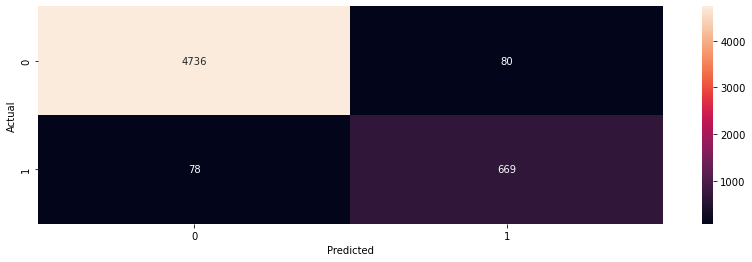

In [318]:

X=df_model_final[df_model_final.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[np.intersect1d(X.columns, df_model.columns)]
X=X.loc[:,~X.columns.duplicated()]

df_model_final['is_spam']=df_model_final['Nature'].apply(lambda x: 1 if x=='spam'else 0)

#initialise model

clf_t = RandomForestClassifier(max_depth=2, random_state=0)
df_model=df_model.loc[:,~df_model.columns.duplicated()]
X_final=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
clf_t.fit(X_final, y_model)


X=df_model_final[df_model_final.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[np.intersect1d(X.columns, df_model.columns)]
X=X.loc[:,~X.columns.duplicated()]


y=df_model_final[['is_spam']]
y_pred=clf_t.predict(X)
cm = confusion_matrix(y,y_pred)

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Ok




https://dimensionless.in/spam-detection-with-natural-language-processing-part-2/

https://www.analyticsvidhya.com/blog/2021/09/performing-email-spam-detection-using-bert-in-python/
